# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Datafiles/cust_seg.csv')
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [3]:
df.duplicated().sum()

0

Looks like we can remove 'Unnamed: 0' and 'Customer Id'. The data is all numeric, so we only need a scaler. Since this is an unsupervised task, we do not need to train test split our data

In [4]:
# dropping columns
df.drop(columns = ['Unnamed: 0','Customer Id'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 53.2 KB


It looks like we have some nulls for Defaulted as well. For now, I want to see how Kmeans handles null values. 

# Scaler and model

In [5]:
# Creating the Scaler and a scaled dataframe
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns = df.columns)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,850.0,-2.152527e-16,1.000589,-1.870097,-0.750235,-0.128089,0.742915,2.609353
Edu,850.0,-1.034467e-16,1.000589,-0.766349,-0.766349,-0.766349,0.312122,3.547538
Years Employed,850.0,-5.642545e-17,1.000589,-1.264543,-0.821666,-0.231164,0.654589,3.607100
Income,850.0,6.478478e-17,1.000589,-0.874220,-0.588657,-0.303094,0.235582,10.366584
Card Debt,850.0,-5.433562e-17,1.000589,-0.736527,-0.562141,-0.325625,0.151408,8.935446
Other Debt,850.0,-7.314411e-17,1.000589,-0.892833,-0.598511,-0.316702,0.242722,9.455440
Defaulted,700.0,-9.389315e-17,1.000715,-0.594950,-0.594950,-0.594950,1.680814,1.680814
DebtIncomeRatio,850.0,2.716781e-17,1.000589,-1.499764,-0.755217,-0.219142,0.540296,4.635308


Because we need to loop through the values for k, we do not need to start with a base model. I will go directly into looping through possible k values from 2 to 25

## Inertia

In [6]:
clusters = np.arange(1, 26, 1)
inertias = pd.DataFrame(index = clusters, columns = ['Inertia'])

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertias.loc[i,'Inertia'] = kmeans.inertia_
    
inertias

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

I'm keeping this error in the notebook because I wanted to see what happened will null values. The model doesn't handle them and spits an error. I will fill nulls with 0 for default, and move on

In [7]:
df['Defaulted'].fillna(0, inplace = True)
# Info to confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        850 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 53.2 KB


In [8]:
# New instance of scaled from above
scaled = scaler.fit_transform(df)

In [9]:
# Rerunning the Inertia loop
clusters = np.arange(2, 26, 1)
inertias = pd.DataFrame(index = clusters, columns = ['Inertia'])

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertias.loc[i,'Inertia'] = kmeans.inertia_
    
inertias

C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

,Inertia
2,5194.15394
3,4339.017294
4,3763.026505
5,3411.070884
6,3103.227818
7,2894.642447
8,2691.795527
9,2552.081445
10,2430.724579
11,2339.494305


<AxesSubplot: >

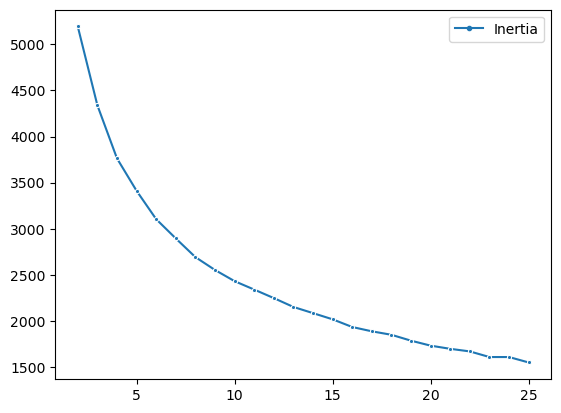

In [10]:
sns.lineplot(data = inertias, markers = '.')

There seems to be a kink around 4 or 5 but its hard to tell. Lets use Silhouette score next

## Silhouette Score

In [11]:
S_scores = pd.DataFrame(index = clusters, columns = ['Silhouette Score'])

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    S_scores.loc[i, 'Silhouette Score'] = silhouette_score(scaled, kmeans.labels_)
    
S_scores

C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

,Silhouette Score
2,0.34248
3,0.287387
4,0.253074
5,0.249648
6,0.19725
7,0.218949
8,0.208975
9,0.207018
10,0.215952
11,0.204071


<AxesSubplot: >

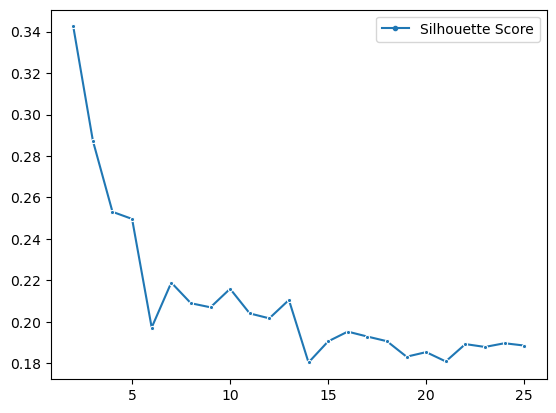

In [12]:
sns.lineplot(data = S_scores, markers = '.')

According to the Silhouette Score for this data and KMeans, the best number of clusters is 2. I will go with the Silhouette Score suggestion and say that our best K is 2

# Extra

In [13]:
bestKmeans = KMeans(n_clusters=2)
bestKmeans.fit(scaled)

C:\Users\Ray\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2)

In [14]:
df['Cluster'] = bestKmeans.labels_
df


,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Cluster
0,41,2,6,19,0.124,1.073,0.0,6.3,1
1,47,1,26,100,4.582,8.218,0.0,12.8,0
2,33,2,10,57,6.111,5.802,1.0,20.9,0
3,29,2,4,19,0.681,0.516,0.0,6.3,1
4,47,1,31,253,9.308,8.908,0.0,7.2,0
...,...,...,...,...,...,...,...,...,...
845,27,1,5,26,0.548,1.220,0.0,6.8,1
846,28,2,7,34,0.359,2.021,0.0,7.0,1
847,25,4,0,18,2.802,3.210,1.0,33.4,1
848,32,1,12,28,0.116,0.696,0.0,2.9,1


In [15]:
df.value_counts(subset = ['Cluster'])

Cluster
1          674
0          176
dtype: int64

We can see that most of the datapoints clustered into cluster 0

In [16]:
pivot = pd.pivot_table(df, index = ['Cluster'])
pivot

,Age,Card Debt,DebtIncomeRatio,Defaulted,Edu,Income,Other Debt,Years Employed
Cluster,,,,,,,,
0,42.590909,4.014068,14.203977,0.210227,1.954545,95.437500,7.52546,16.255682
1,33.054896,0.940387,9.118694,0.216617,1.646884,33.942136,1.91762,6.557864


We can see a clear difference in the means of each metric except for Defaulted. That seems to be relatively evenly distributed between both clusters. Cluster 1 is older, with more income, but more debt and a slightly higher default rate